# QAOA Weighted MAXSAT

Gahwon Lee, Andrew Tan

In [44]:
import qiskit
import numpy as np
import random as rand
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Introduction

### Weighted MAXSAT

Given a boolean formula in conjunctive normal form as well as weights to each clause, find the set of boolean variables that maximize the weights. For example, if a clause with weight 3 is true, then add 3 to the total weight.

There are variants MAXSAT that further restrict the input space. For example, 3-SAT is a similar problem except that each clause can contain exactly three boolean variables.

### QAOA

Quantum Approximation Optimization Algorithm is designed to approximate the Quantum Adiabatic Algorithm by splitting up different time slices into separate gates. Since it approximates the QAA, as the number of gates increases to infinity, the QAOA result will also increase to the ideal state.

## Methods

### Encoding Qubits

The bitstring corresponding to the output of QAOA will be the input qubits. Each qubit will either be 1 for true or 0 for false. 

### Cost and Driver Hamiltonians *C* and *B*

(3-SAT) $C = \sum_{m=0}^M W_m(I-\frac{1}{2}((I_1 \pm Z_1)\otimes (I_2 \pm Z_2)\otimes (I_3 \pm Z_3)))$

(2-SAT) $C = \sum_{m=0}^M W_m(I-\frac{1}{2}((I_1 \pm Z_1)\otimes (I_2 \pm Z_2)))$

$B = \sum_{k=0}^{n-1} X_k$

### Driver Gate W

$W(\beta) = \prod_{k=0}^{n-1}H_k \prod_{k=1}^{n-1}C_{k,0}^{X}    U_{0}(2\beta) \prod_{k=1}^{n-1}C_{k,0}^{X} \prod_{k=0}^{n-1}H_k$

In [45]:
def ref_gate(n, qc, q, beta):
    # W gate
    for i in range(0,n):
        qc.h(q[i])
    for i in range(1,n):
        qc.cx(q[i],q[0])
        
    # apply phase gate
    qc.u1(2*beta, q[0])
    
    for i in range(n-1,0,-1):
        qc.cx(q[i],q[0])
    for i in range(0,n):
        qc.h(q[i])

### Cost Gate V

$V(\gamma) = C_{x,y} U_{y}(\pm\gamma weight) C_{x,y} U_{x}(\pm\gamma weight) U_{y}(\pm\gamma weight)$

The $\pm$ changes whether the $x$ variable is $\neg x$.

In [46]:
def constraint_gate(n, qc, q, gamma, clauses):
    # V gate
    # 2-SAT
    
    # clause[0] is the weight
    # clauses will be in form clauses[i] = [-1*x,y] with x and y refering to the qubits we act on, and a negative value
    # means a NOT-x
    # clauses are also 1-indexed, so be sure to subtract by 1 before reading them!
    for clause in clauses:
        weight = clause[0]
        x = abs(clause[1]) - 1
        x_not = clause[1] < 0
        # see if the x boolean is a NOT-x
        y = abs(clause[2]) - 1
        y_not = clause[2] < 0
        
        
        flip = 2*(x_not == y_not) - 1 # flips if x_not xor y_not
        qc.cx(q[x],q[y])
        qc.u1(flip*-1*gamma*weight,q[y])
        qc.cx(q[x],q[y])

        flip = -(2*(x_not)-1) # x
        qc.u1(flip*-1*gamma*weight,q[x])

        flip = -(2*(y_not)-1) # y
        qc.u1(flip*-1*gamma*weight,q[y])

### Classic Solver

In [ ]:
def classic(clauses, value):
    # given an input value it will return the total weight
    value = value[::-1]
    res = 0
    
    for clause in clauses:
        weight = clause[0]
        x = abs(clause[1]) - 1
        x_not = clause[1] < 0
        # see if the x boolean is a NOT-x
        y = abs(clause[2]) - 1
        y_not = clause[2] < 0
        
        result = ((value[x] == '1') != x_not) or ((value[y] == '1') != y_not)
        if (result):
            res += weight
            
    return res

### Calculating the Expectation
Expectation = $\langle \gamma,\beta\left|C\right|\gamma,\beta\rangle$

In [87]:
def run_qaoa(qc,q,c,n,gamma,beta,clauses):
    for i in range(n):
        qc.h(q[i])
    p = 1
    for pp in range(p):
        constraint_gate(n, qc, q, gamma, clauses)
        ref_gate(n, qc, q, beta)

def expectation(gamma, beta, clauses):
    
    n = 3
    q = qiskit.QuantumRegister(n)
    c = qiskit.ClassicalRegister(n)
    qc = qiskit.QuantumCircuit(q,c)
    # q[0..n-1] are input qubits
    
    run_qaoa(qc,q,c,n,gamma,beta,clauses)
    
    qc.measure(q, c)
    
    repetitions = 1024
    job = qiskit.execute(qc, backend='local_qasm_simulator', shots=repetitions)
    result = job.result().get_counts(qc)
    
    answer = 0
    for key in result.keys():
        probability = result[key] / repetitions
        answer += probability * classic(clauses, key)
        
    return answer
    
print("Expectation: "+str(expectation(math.pi/6,math.pi/2, [[1,1,2],[2,-1,-2],[1,-1,2],[2,1,-2]])))

Expectation: 4.5107421875


### Classically Optimizing *γ* and *β*

Randomly pick γ and β and find the best input bitstring.

We chose this method over gradient descent because there are several local maximums for our cost function.

Our cnf are encoded as a list of 3-element lists. Each element begins with the weight of the clause, then the 1-indexed variable to use. The negative sign means to apply $not$ on the following variable.

For example, the cnf $(a \vee b)_3 \wedge (a \vee \neg b)_5$ (where subscript denotes the weight of each clause) can be represented by [[3,1,2],[5,1,-2]]

In [106]:
cnf = [[1,1,3],[1,-1,-2],[1,1,-3],[1,-3,2]]
max = 0
best_gamma = 0
best_beta = 0
best_exp = 0
for i in range(16):
    beta = rand.uniform(0,math.pi * 2)
    gamma = rand.uniform(0,math.pi)
    exp = expectation(gamma,beta,cnf)
    if exp > best_exp:
        best_gamma = gamma
        best_beta = beta
        best_exp = exp
    print("Expectation: "+str(exp))
print("Best Expectation: "+str(best_exp)+"|Best gamma: "+str(best_gamma)+"|Best beta: "+str(best_beta))

Expectation: 2.962890625
Expectation: 2.81640625
Expectation: 3.203125
Expectation: 3.130859375
Expectation: 2.9873046875
Expectation: 2.7919921875
Expectation: 2.880859375
Expectation: 3.1328125
Expectation: 2.94140625
Expectation: 2.9345703125
Expectation: 3.2216796875
Expectation: 2.978515625
Expectation: 2.775390625
Expectation: 2.84765625
Expectation: 3.0341796875
Expectation: 2.9453125
Best Expectation: 3.2216796875|Best gamma: 0.88174771792973|Best beta: 0.7750681263962387


### Plotting
We kept the $\beta$ value constant. The blue line represents the mean of 16 expectations given the same $\gamma$. The red line represents the standard deviation of those expectations.

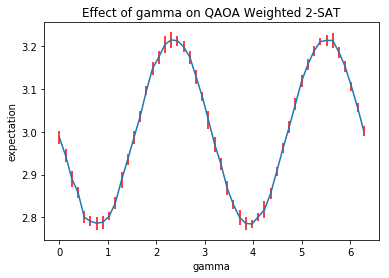

In [89]:
g = np.linspace(0, 2 * math.pi, 50)
b = 5 * math.pi / 6
# cnf = [[1,1,2],[1,-1,2],[1,1,-2],[1,-1,-2],[1,1,3],[1,-1,3],[2,1,-3],[3,-1,-3],[1,2,3],[2,-2,3],[1,2,-3],[2,-2,-3]]
cnf = [[1,1,3],[1,-1,-2],[1,1,-3],[1,-3,2]]

# clause format is [weight,1st var, 2nd var]
def f(x):
    return expectation(x, b, cnf)

expectations = [[f(x) for i in range(16)] for x in g]
means = np.array([np.mean(x) for x in expectations])
stds = np.array([np.std(x) for x in expectations])

plt.errorbar(g, means, yerr=stds, fmt='-', ecolor='red')
plt.xlabel('gamma')
plt.ylabel('expectation')
plt.title('Effect of gamma on QAOA Weighted 2-SAT')
plt.show()

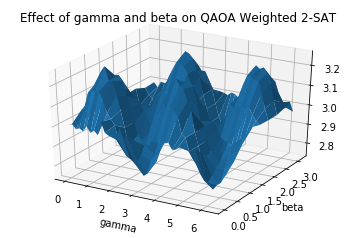

In [78]:
g = np.linspace(0, 2 * math.pi, 40)
b = np.linspace(0, math.pi, 10)
gamma, beta = np.meshgrid(g, b)
cnf = [[1,1,3],[1,-1,-2],[1,1,-3],[1,-3,2]]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(gamma, beta, np.array([expectation(x, y, cnf) for x,y in zip(np.ravel(gamma), np.ravel(beta))]).reshape(gamma.shape))

plt.xlabel('gamma')
plt.ylabel('beta')

plt.title('Effect of gamma and beta on QAOA Weighted 2-SAT')
plt.show()

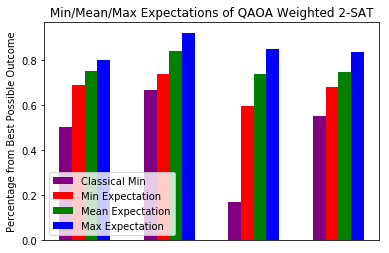

In [100]:
cnfs = [
    [[1,1,3],[1,-1,-2],[1,1,-3],[1,-3,2]],
    [[2,1,2],[3,-1,-2],[4,1,-2],[1,-1,2]],
    [[1,-1,3],[2,-1,2],[1,-1,-3],[2,-3,2]],
    [[5,1,3],[4,2,3],[3,1,2],[2,1,-3],[1,2,-3],[5,1,-2],[4,-1,3],[3,-2,3],[2,-1,2]]
]
mins = []
maxs = []
avgs = []
classic_values = [classic_maxsat(cnf, 2, 3, print_values=False) for cnf in cnfs]
worst = [w / b for (b, w) in classic_values]

numTries = 32

for index in range(len(cnfs)):
    cnf = cnfs[index]
    currMin = None
    currMax = None
    currSum = 0
    b, w = classic_values[index]
    
    for i in range(numTries):
        beta = rand.uniform(0,math.pi * 2)
        gamma = rand.uniform(0,math.pi)
        val = expectation(beta, gamma, cnf)
        
        if currMin == None or currMin > val:
            currMin = val
        if currMax == None or currMax < val:
            currMax = val
        currSum += val
        
    mins.append(currMin / b)
    maxs.append(currMax / b)
    avgs.append((currSum / numTries) / b)
    
inputs = np.array([(i + 1) for i in range(len(cnfs))])
bars = plt.figure()
ax = plt.subplot(111)
ax.bar(inputs-0.3, worst,width=0.15,color='purple',align='center', label='Classical Min')
ax.bar(inputs-0.15, mins,width=0.15,color='r',align='center', label='Min Expectation')
ax.bar(inputs, avgs,width=0.15,color='g',align='center', label='Mean Expectation')
ax.bar(inputs+0.15, maxs,width=0.15,color='b',align='center', label='Max Expectation')
ax.legend(loc='lower left')

plt.title('Min/Mean/Max Expectations of QAOA Weighted 2-SAT')
plt.gca().axes.get_xaxis().set_ticks([])
plt.ylabel('Percentage from Best Possible Outcome')
plt.show()

Above, we tested 4 different 2-SAT problems on the QAOA. All values are calculated by $\frac{Absolute\ Value}{Classical\ Maximum}$

## Results and Discussion

As you can see the 2D and 3D graphs above, our simple 2SAT problem has some very stable curves. Be warned, these graphs take several minutes to create.

Our classical optimization algorithm almost always gets the correct value, but that is because we iterate 8 times.

### Weighted 3SAT

We decided to expand our experiment to include 3-SAT as well.

In [12]:
### Weighted 3SAT
def constraint_3sat(n, qc, q, gamma, clauses):
    for clause in clauses:

        weight = clause[0]
        x = abs(clause[1]) - 1
        x_not = clause[1] < 0
        # see if the x boolean is a NOT-x
        y = abs(clause[2]) - 1
        y_not = clause[2] < 0
        z = abs(clause[3]) - 1
        z_not = clause[3] < 0

        flip = 2*((x_not+y_not+z_not)%2 == 0) - 1
        qc.cx(q[z],q[x])
        qc.cx(q[y],q[x])
        qc.u1(flip*-1 * gamma * weight,q[x])
        qc.cx(q[y],q[x])
        qc.cx(q[z],q[x])

        flip = 2*(z_not == y_not) - 1 # flips if z_not xor y_not
        qc.cx(q[y],q[z])
        qc.u1(flip * -1 * gamma * weight,q[z])
        qc.cx(q[y],q[z])

        flip = 2*(x_not == y_not) - 1 # flips if x_not xor y_not
        qc.cx(q[y],q[x])
        qc.u1(flip * -1 * gamma * weight,q[x])
        qc.cx(q[y],q[x])

        flip = 2*(x_not == z_not) - 1 # flips if z_not xor x_not
        qc.cx(q[z],q[x])
        qc.u1(flip * -1 * gamma * weight,q[x])
        qc.cx(q[z],q[x])

        flip = -(2*(x_not)-1) # x
        qc.u1(flip*-1*gamma*weight,q[x])

        flip = -(2*(y_not)-1) # y
        qc.u1(flip*-1*gamma*weight,q[y])

        flip = -(2*(z_not)-1) # z
        qc.u1(flip*-1*gamma*weight,q[z])


### Classic 3SAT Verifier

In [13]:
def classic_3sat(clauses, value):
    value = value[::-1]
    res = 0
    
    for clause in clauses:
        weight = clause[0]
        x = abs(clause[1]) - 1
        x_not = clause[1] < 0
        # see if the x boolean is a NOT-x
        y = abs(clause[2]) - 1
        y_not = clause[2] < 0
        z = abs(clause[3]) - 1
        z_not = clause[3] < 0
        
        result = ((value[x] == '1') != x_not) or ((value[y] == '1') != y_not) or ((value[z] == '1') != z_not)
        if (result):
            res += weight
            
    return res

### Functions to run QAOA and calculate the Expectation value

In [14]:
def run_qaoa_3sat(qc,q,c,n,gamma,beta,clauses):
   
    constraint_3sat(n, qc, q, gamma, clauses)
    ref_gate(n, qc, q, beta)

def expectation_3sat(n, gamma, beta, prev_gamma, prev_beta, clauses):
    
    q = qiskit.QuantumRegister(n)    # q[0..n-1] are input qubits (they're all input qubits)
    c = qiskit.ClassicalRegister(n)
    qc = qiskit.QuantumCircuit(q,c)
    for i in range(n):
        # Apply the hadamards to the qubits
        qc.h(q[i])
        
    for i in range(len(prev_gamma)):
        # Apply every previous iteration's (beta, gamma) value
        run_qaoa_3sat(qc,q,c,n,prev_gamma[i],prev_beta[i],clauses)

    run_qaoa_3sat(qc,q,c,n,gamma,beta,clauses)
    qc.measure(q, c)

    repetitions = 1024
    job = qiskit.execute(qc, backend='local_qasm_simulator', shots=repetitions)
    result = job.result().get_counts(qc)

    answer = 0
    for key in result.keys():
        probability = result[key] / repetitions
        answer += probability * classic_3sat(clauses, key)

    #print("Resulting bitstring after 1024 shot: "+str(result))

    return answer
#print("Expectation: "+str(expectation(math.pi/6,math.pi/2, [[1,1,2,3],[2,1,-2,3],[1,-1,2,4],[2,1,-2,3]])))

### Running QAOA for 3SAT

In [42]:
#cnf = [[1,1,2,3],[2,1,2,-3],[1,1,-2,3],[3,1,-2,-3],[2,-1,2,3],[1,-1,2,-3],[1,-1,-2,3],[1,-1,-2,-3]]
cnf = [[1,4,3,5],[1,-4,-5,-1],[1,5,-2,-6],[1,-4,-5,-2],[1,1,3,-5],[1,-4,-3,1],[1,5,-3,4],[1,-1,2,-4],[1,-2,6,5],[1,-3,-6,-2],[1,-3,1,-6],[1,-3,-4,1],[1,4,1,5],[1,3,-4,-1],[1,-1,5,-2],[1,2,-6,-3],[1,6,3,1],[1,-2,5,3],[1,1,-6,5],[1,-5,-6,-3],[1,1,2,-5],[1,3,-1,-4],[1,-3,2,-5],[1,5,6,-4],[1,6,3,-5],[1,-2,-1,3],[1,2,1,6],[1,-1,-5,2],[1,-4,1,3],[1,4,-6,-2],[1,-1,3,6],[1,5,-6,3],[1,-6,1,-4],[1,-4,1,5],[1,-3,6,-1],[1,-5,-2,1],[1,1,6,5],[1,-3,5,2],[1,-4,5,2],[1,5,-1,3],[1,-2,6,5],[1,3,4,5],[1,-6,3,1],[1,4,-1,5],[1,-4,6,-2],[1,-6,5,3],[1,3,-2,-1],[1,-6,-5,-2],[1,4,6,2],[1,-5,4,3],[1,3,4,-5],[1,4,5,-6],[1,-3,-6,-2],[1,5,-4,3],[1,1,-4,-3],[1,2,5,-4],[1,4,5,-2],[1,-3,-1,5],[1,-5,6,-2],[1,-1,-5,-6],]
classic3sat(cnf, 6)
print()

max = 0
best_bitstring = ""
n = 6
depth = 4
trials = 16
best_expectation = []
best_gamma = []
best_beta = []
for p in range(depth):
    best_expectation.append(0)
    best_gamma.append(0)
    best_beta.append(0)
    average = 0
    for i in range(trials):

        beta = rand.uniform(0,math.pi)
        gamma = rand.uniform(0,math.pi/2)
        expectation = expectation_3sat(n,gamma,beta,best_gamma,best_beta,cnf)
        print("Expectation: "+str(expectation))
        if expectation > best_expectation[p]:
            best_gamma[p] = gamma
            best_beta[p] = beta
            best_expectation[p] = expectation
        average += expectation
    average = average/trials
    print("p="+str(p)+": (gamma,beta): ("+str(best_gamma[p])+","+str(best_beta[p])+") | expectation: "+str(best_expectation[p])+"| average: "+str(average))
#print("Best Bitstring is "+ best_bitstring+" | Cost: "+str(max))



Maximum Expectation: 58
Minimum Expectation: 46
Best Inputs:
010110
010111

Expectation: 52.0205078125
Expectation: 53.09765625
Expectation: 52.677734375
Expectation: 52.6875
Expectation: 52.3857421875
Expectation: 52.8759765625
Expectation: 52.982421875
Expectation: 52.6259765625
Expectation: 52.998046875
Expectation: 52.4375
Expectation: 52.5244140625
Expectation: 52.328125
Expectation: 52.5654296875
Expectation: 52.171875
Expectation: 53.25390625
Expectation: 52.8515625
p=0: (gamma,beta): (0.3807317012228337,0.3484940603652552) | expectation: 53.25390625| average: 52.6552734375
Expectation: 52.25
Expectation: 52.3447265625
Expectation: 52.396484375
Expectation: 51.7529296875
Expectation: 53.130859375
Expectation: 52.4287109375
Expectation: 52.1962890625
Expectation: 52.1943359375
Expectation: 51.966796875
Expectation: 52.671875
Expectation: 52.05078125
Expectation: 52.2646484375
Expectation: 52.8583984375
Expectation: 52.591796875
Expectation: 52.0439453125
Expectation: 52.981445312

### Graph 3SAT

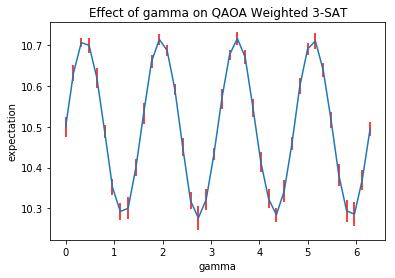

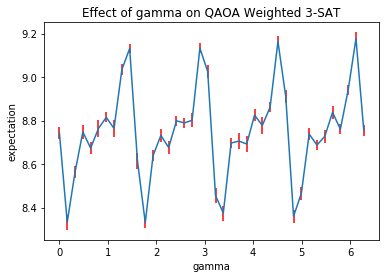

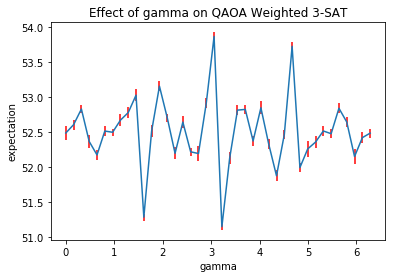

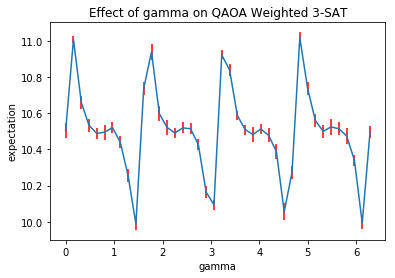

In [107]:
def graph_3sat(cnf, b, num_qubits):
    g = np.linspace(0, 2 * math.pi, 40)
    def f(x):
        return expectation_3sat(num_qubits, x, b, [], [], cnf)

    expectations = [[f(x) for i in range(16)] for x in g]
    means = np.array([np.mean(x) for x in expectations])
    stds = np.array([np.std(x) for x in expectations])

    plt.errorbar(g, means, yerr=stds, fmt='-', ecolor='red')
    
    plt.xlabel('gamma')
    plt.ylabel('expectation')
    plt.title('Effect of gamma on QAOA Weighted 3-SAT')
    plt.show()


cnf = [[1,1,2,3],[2,1,2,-3],[1,1,-2,3],[3,1,-2,-3],[2,-1,2,3],[1,-1,2,-3],[1,-1,-2,3],[1,-1,-2,-3]]
graph_3sat(cnf, math.pi / 6, 3)
cnf = [[1,-5,3,-1],[1,4,3,-1],[1,2,-1,-5],[1,5,-3,-6],[1,1,3,4],
       [1,-2,5,6],[1,3,-6,-5],[1,4,-2,-6],[1,-1,-2,5],[1,1,-3,-4]]
graph_3sat(cnf, 2.25, 6)
cnf = [[1,4,3,5],[1,-4,-5,-1],[1,5,-2,-6],[1,-4,-5,-2],[1,1,3,-5],[1,-4,-3,1],[1,5,-3,4],[1,-1,2,-4],[1,-2,6,5],[1,-3,-6,-2],[1,-3,1,-6],[1,-3,-4,1],[1,4,1,5],[1,3,-4,-1],[1,-1,5,-2],[1,2,-6,-3],[1,6,3,1],[1,-2,5,3],[1,1,-6,5],[1,-5,-6,-3],[1,1,2,-5],[1,3,-1,-4],[1,-3,2,-5],[1,5,6,-4],[1,6,3,-5],[1,-2,-1,3],[1,2,1,6],[1,-1,-5,2],[1,-4,1,3],[1,4,-6,-2],[1,-1,3,6],[1,5,-6,3],[1,-6,1,-4],[1,-4,1,5],[1,-3,6,-1],[1,-5,-2,1],[1,1,6,5],[1,-3,5,2],[1,-4,5,2],[1,5,-1,3],[1,-2,6,5],[1,3,4,5],[1,-6,3,1],[1,4,-1,5],[1,-4,6,-2],[1,-6,5,3],[1,3,-2,-1],[1,-6,-5,-2],[1,4,6,2],[1,-5,4,3],[1,3,4,-5],[1,4,5,-6],[1,-3,-6,-2],[1,5,-4,3],[1,1,-4,-3],[1,2,5,-4],[1,4,5,-2],[1,-3,-1,5],[1,-5,6,-2],[1,-1,-5,-6],]
graph_3sat(cnf, math.pi / 7 * 5, 6)
cnf = [[1,3,6,2],[1,10,-7,-3],[1,-2,-5,3],[1,-5,3,-4],[1,-9,-4,-7],[1,3,-5,10],[1,2,-1,-4],[1,-5,7,1],[1,10,-8,-3],[1,9,7,-2],[1,-2,-3,-10],[1,8,6,-1],]
graph_3sat(cnf, 0.78, 10)

### 3D Plots

Below, we exported a range of expectations into a file and imported them into plot.ly.

In [31]:
#cnf = [[1,4,3,5],[1,-4,-5,-1],[1,5,-2,-6],[1,-4,-5,-2],[1,1,3,-5],[1,-4,-3,1],[1,5,-3,4],[1,-1,2,-4],[1,-2,6,5],[1,-3,-6,-2],[1,-3,1,-6],[1,-3,-4,1],[1,4,1,5],[1,3,-4,-1],[1,-1,5,-2],[1,2,-6,-3],[1,6,3,1],[1,-2,5,3],[1,1,-6,5],[1,-5,-6,-3],[1,1,2,-5],[1,3,-1,-4],[1,-3,2,-5],[1,5,6,-4],[1,6,3,-5],[1,-2,-1,3],[1,2,1,6],[1,-1,-5,2],[1,-4,1,3],[1,4,-6,-2],[1,-1,3,6],[1,5,-6,3],[1,-6,1,-4],[1,-4,1,5],[1,-3,6,-1],[1,-5,-2,1],[1,1,6,5],[1,-3,5,2],[1,-4,5,2],[1,5,-1,3],[1,-2,6,5],[1,3,4,5],[1,-6,3,1],[1,4,-1,5],[1,-4,6,-2],[1,-6,5,3],[1,3,-2,-1],[1,-6,-5,-2],[1,4,6,2],[1,-5,4,3],[1,3,4,-5],[1,4,5,-6],[1,-3,-6,-2],[1,5,-4,3],[1,1,-4,-3],[1,2,5,-4],[1,4,5,-2],[1,-3,-1,5],[1,-5,6,-2],[1,-1,-5,-6],]
cnf = [[1,-5,3,-1],[1,4,3,-1],[1,2,-1,-5],[1,5,-3,-6],[1,1,3,4],[1,-2,5,6],[1,3,-6,-5],[1,4,-2,-6],[1,-1,-2,5],[1,1,-3,-4]]
def get_graph(cnf):
    betas = [math.pi/20*i for i in range(1,21)]
    gammas = [math.pi/20*i for i in range(1,41)]
    with open('output.csv', 'w') as f:
        for beta in betas:
            for gamma in gammas:
                f.write(str(expectation_3sat(6,gamma,beta,[],[],cnf))+",")
            f.write("\n")
    with open('output2.csv', 'w') as f:
        for beta in betas:
            f.write(str(beta)+",\n")
    with open('output3.csv', 'w') as f:
        for gamma in gammas:
            f.write(str(gamma)+",\n")
            
get_graph(cnf)
            
    

#### 3D Graph Results

https://plot.ly/~creativitRy/2

https://plot.ly/~creativitRy/13

These two plots of different unweighted 3-SAT with p=1 look similar. Both their local minimums and maximums seem to rest along $\beta \approx 2.25$ and $\beta \approx 0.75$. This could be a coincidence since they both use 6 variables.

### Misc

#### Random Instances of n-SAT Generation

https://toughsat.appspot.com/

In [ ]:
import sys

def parse_sat():
    i =0
    print("[",end="")
    for line in sys.stdin:
        if i< 2:
            i += 1
            continue
        l = line.split(" ")
        print("[1,"+l[0]+","+l[1]+","+l[2]+"]", end = ",")
    print("]")

### Classic n-SAT Solver
For testing only

In [78]:
def classic_maxsat(clauses, clause_len, n, print_values=True):
    """clauses = cnf to solve, n = number of variables used"""
    ans = [0] * (2 ** n)
    for clause in clauses:
        weight = clause[0]
        sat = [False] * (2 ** n)
        for i in range(1, clause_len + 1):
            var = abs(clause[i]) - 1
            negate = clause[i] < 0
            for j in range(0, len(sat)):
                if ((j & (1 << var)) != 0) != negate:
                    sat[j] = True
        for i in range(0, len(sat)):
            if sat[i]:
                ans[i] += weight
    
    maxExpectationIndex = 0
    maxExpectationIndices = [0]
    minExpectationIndex = 0
    for i in range(1, len(ans)):
        if ans[i] > ans[maxExpectationIndex]:
            maxExpectationIndices = [i]
            maxExpectationIndex = i
        elif ans[i] == ans[maxExpectationIndex]:
            maxExpectationIndices.append(i)
        
        if ans[i] < ans[minExpectationIndex]:
            minExpectationIndex = i
    
    if print_values:
        print("Maximum Outcome: " + str(ans[maxExpectationIndex]))
        print("Minimum Outcome: " + str(ans[minExpectationIndex]))
        print("Inputs that achieve the max:")
        for i in maxExpectationIndices:
            print(format(i, "0" + str(n) + "b"))
    
    return ans[maxExpectationIndex], ans[minExpectationIndex]

def classic3sat(clauses, n, print_values=True):
    return classic_maxsat(clauses, 3, n, print_values)

## Conclusion

### Was QAOA effective in finding decent solutions?

Yes, but by the nature of Max-SAT, many bitstring would have been a decently close to the maximum weight.

### What % of the optimum solution did QAOA achieve?

QAOA constantly got around 80% the optimal solution with a depth of 1. However, this is likely due to the fact that our functions were extremely simple and trivial to solve. We used simple functions to test QAOA because the computer could not efficiently simulate a quantum computer for more than a few qubits. And because the nature of expectation values, it is incredibly unlikely to achieve the optimal solution.

### Does the technique have any issues?

Calculating the Expectation value takes ages because we have to run multiple shots, and for each of those shots we have to evaluate the bitstring pertaining to that shot classically. Because there's so many shots, there is likely to be $O(2^n)$ classical evaluations, destroying the optimization part of this algorithm.

### Future research direction

Right now the bottleneck is calculating the expectation value. If there were a way to calculate (whether quantumly or classically) the expectation value of an arbitrary matrix, it would immensely speedup the process. Also, looking into different options for the classically optimizing of $\beta$ and $\gamma$ values, as the absence of any coherent gradient makes gradient descent obsolete. Finally, for 2 and 3-SAT, we noticed the graphs followed the same general sinusoidal pattern. Finding out why this pattern exists could serve as an interesting problem. It could also be the basis of a better, faster classical optimizer.